In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


Trial 10 Complete [00h 00m 39s]
val_accuracy: 0.7900000214576721

Best val_accuracy So Far: 0.7900000214576721
Total elapsed time: 00h 06m 13s
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - accuracy: 0.8437 - loss: 0.8870 - val_accuracy: 0.1050 - val_loss: 132.6934
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8586 - loss: 0.8042 - val_accuracy: 0.1050 - val_loss: 93.7034
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8819 - loss: 0.7756 - val_accuracy: 0.1050 - val_loss: 88.2756
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9034 - loss: 0.7336 - val_accuracy: 0.1250 - val_loss: 68.8423
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8691 - loss: 0.7637 - val_accuracy: 0.1250 - val_loss: 109.8669
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8900 - loss: 0.7421 - val_accuracy: 0.1250 - val_loss: 61.2066
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9048 - loss: 0.7068 - val_accuracy: 0.1250 - val_loss: 123.0483
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8877 - loss: 0.7326 - val_accuracy: 0.1250 - 

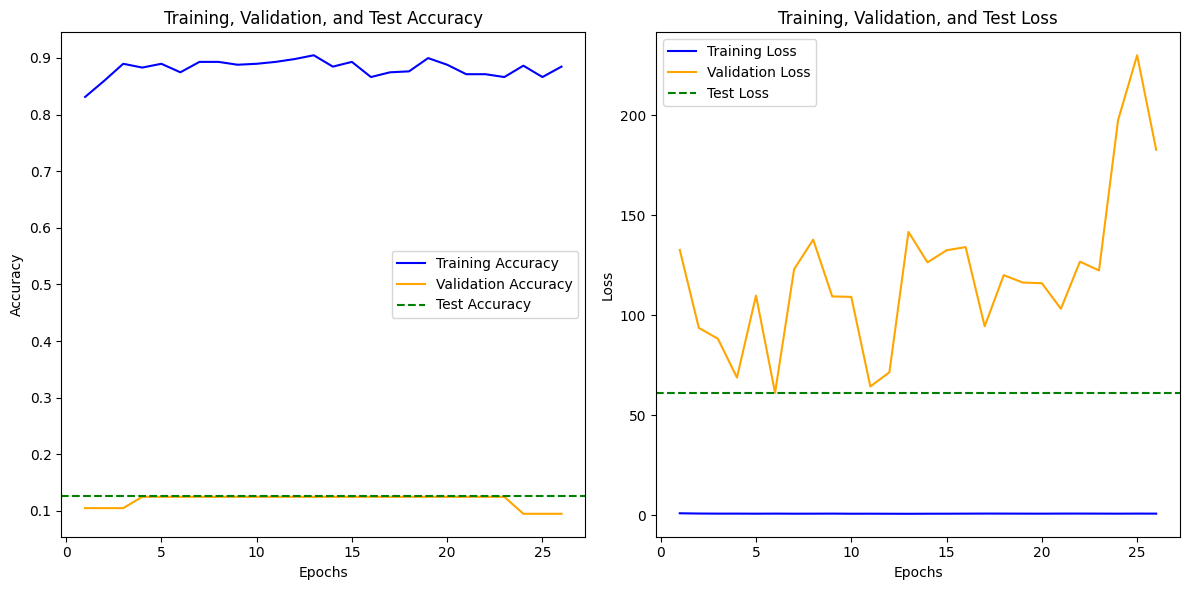

In [2]:


0-import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load and filter the dataset
min_faces_per_person = 100
lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=0.4)

# Flatten images and normalize
X = lfw_people.data / 255.0
y = lfw_people.target

# Split the dataset into training and test sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, train_size=0.7, stratify=y, random_state=0
)

# Further split the temporary training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, train_size=0.75, stratify=y_train_temp, random_state=0
)

# Reshape the input data to match the model's expected input shape
X_train_cnn = X_train.reshape(-1, 50, 37, 1)
X_val_cnn = X_val.reshape(-1, 50, 37, 1)
X_test_cnn = X_test.reshape(-1, 50, 37, 1)

# Define the function to create a Keras model with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(50, 37, 1),
                     kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters=hp.Int('filters_2', min_value=64, max_value=128, step=32),
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters=hp.Int('filters_3', min_value=128, max_value=256, step=64),
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(lfw_people.target_names.shape[0], activation='softmax'))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train_cnn)

# Initialize Keras Tuner with Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner',
    project_name='lfw_tuning'
)

# Run the search
tuner.search(
    datagen.flow(X_train_cnn, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val_cnn, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        # ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)

# Retrieve the best model and evaluate it
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(
    datagen.flow(X_train_cnn, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val_cnn, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        # ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_cnn, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Function to plot training, validation, and test metrics
def plot_training_history(history, test_accuracy, test_loss):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.axhline(y=test_accuracy, color='green', linestyle='--', label='Test Accuracy')
    plt.title('Training, Validation, and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.axhline(y=test_loss, color='green', linestyle='--', label='Test Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the history of the best model along with test metrics
plot_training_history(history, test_accuracy, test_loss)
